# Environment Setup

In [3]:
#!pip install pyspark pyspark_dist_explore

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.8 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285413 sha256=82586b402cd3913a979524425a0c532e9ad67406c02e4ef8cd52b3edd8e8edd2
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [4]:
# basic data science imports
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# pyspark imports
from pyspark import SparkContext
from pyspark.sql import functions as f, SparkSession, Column
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt
from pyspark.ml.fpm import FPGrowth

# util imports
import os
for dirname, _, filenames in os.walk('dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings
warnings.filterwarnings('ignore')

/kaggle/input/groceries-dataset-for-market-basket-analysismba/Groceries data.csv
/kaggle/input/groceries-dataset-for-market-basket-analysismba/basket.csv
/kaggle/input/market-basket-analysis/Assignment-1_Data.xlsx
/kaggle/input/market-basket-analysis/Assignment-1_Data.csv


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Creating a spark session

In [5]:
spark = SparkSession.builder \
        .appName("arlUsingPyspark") \
        .getOrCreate()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/20 09:13:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Data Loading

In [7]:
root = "dataset/"

In [8]:
df = spark.read.csv(root+"basket.csv", header=True).withColumn("id", f.monotonically_increasing_id())
df.show(5)

+-----------+------------------+-------------------+------+----+----+----+----+----+----+----+---+
|          0|                 1|                  2|     3|   4|   5|   6|   7|   8|   9|  10| id|
+-----------+------------------+-------------------+------+----+----+----+----+----+----+----+---+
| whole milk|            pastry|        salty snack|  null|null|null|null|null|null|null|null|  0|
|    sausage|        whole milk|semi-finished bread|yogurt|null|null|null|null|null|null|null|  1|
|       soda|pickled vegetables|               null|  null|null|null|null|null|null|null|null|  2|
|canned beer|   misc. beverages|               null|  null|null|null|null|null|null|null|null|  3|
|    sausage|  hygiene articles|               null|  null|null|null|null|null|null|null|null|  4|
+-----------+------------------+-------------------+------+----+----+----+----+----+----+----+---+
only showing top 5 rows



In [9]:
df_all = spark.read.csv(root+"Groceries data.csv", header=True).withColumn("id", f.monotonically_increasing_id())
df_all.show(5)

+-------------+----------+----------------+----+-----+---+-----------+---+
|Member_number|      Date| itemDescription|year|month|day|day_of_week| id|
+-------------+----------+----------------+----+-----+---+-----------+---+
|         1808|2015-07-21|  tropical fruit|2015|    7| 21|          1|  0|
|         2552|2015-05-01|      whole milk|2015|    5|  1|          4|  1|
|         2300|2015-09-19|       pip fruit|2015|    9| 19|          5|  2|
|         1187|2015-12-12|other vegetables|2015|   12| 12|          5|  3|
|         3037|2015-01-02|      whole milk|2015|    1|  2|          4|  4|
+-------------+----------+----------------+----+-----+---+-----------+---+
only showing top 5 rows



# Data Preprocessing

### Item count in Customer's basket `num_basket`

In [10]:
num_baskets = df_all.groupBy('Member_number').count()
num_baskets.show()

+-------------+-----+
|Member_number|count|
+-------------+-----+
|         2904|   10|
|         3959|   14|
|         2294|   23|
|         4032|    4|
|         1512|   10|
|         4937|   16|
|         2069|   10|
|         1159|    6|
|         3414|   13|
|         3210|    8|
|         2136|    2|
|         1436|    2|
|         1090|   12|
|         2162|   10|
|         4821|   14|
|         1572|   20|
|         2088|    5|
|         3606|    2|
|         4975|   13|
|         3368|    6|
+-------------+-----+
only showing top 20 rows



Text(0.5, 0, 'No. of Customers')

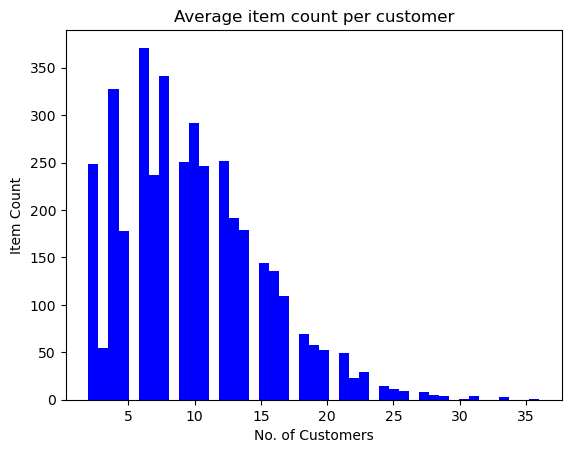

In [11]:
fig, ax = plt.subplots()

hist(ax, num_baskets.select('count'), bins=45, color=['blue'])

plt.title('Average item count per customer')
plt.ylabel('Item Count')
plt.xlabel('No. of Customers')

### Formatting dataset : Basket DataFrame `df_basket`

In [12]:
# formatting 
df_basket = df.select('id', f.array([df[c] for c in df.columns[:-1]]).alias('basket'))
df_basket = df_basket.select('id', f.array_except("basket", f.array(f.lit(None))).alias('basket'))

df_basket.printSchema() # To view dataframe Schema

root
 |-- id: long (nullable = false)
 |-- basket: array (nullable = false)
 |    |-- element: string (containsNull = true)



In [13]:
df_basket.show(5, False)

+---+--------------------------------------------------+
|id |basket                                            |
+---+--------------------------------------------------+
|0  |[whole milk, pastry, salty snack]                 |
|1  |[sausage, whole milk, semi-finished bread, yogurt]|
|2  |[soda, pickled vegetables]                        |
|3  |[canned beer, misc. beverages]                    |
|4  |[sausage, hygiene articles]                       |
+---+--------------------------------------------------+
only showing top 5 rows



## Training FPGrowth model

#### Support 
Support is simply the probability of an event to occur.
$$
Support (A) = P(A)
$$

If we have an event to buy a product *A*, $Support(A)$ is simply the number of transactions which includes *A* divided by the total number of transactions.

$$
Support (A) = \frac{Number~of~Transactions~with~A}{Total~Number~of~Transactions}
$$

#### Confidence 
Confidence is a measure that indicates how often an associated event *B* occurs when an event *A* has occured.

It quantifies the strength of the relationship between A and B.

If we have an association rule ${A \Rightarrow B}$, the confidence of this rule is calculated as:

$$
\text{Confidence}(A \Rightarrow B) = \frac{\text{Support}(A \cap B)}{\text{Support}(A)}
$$
where:
- $\text{Support}(A \cap B)$ is the number of transactions where both items A and B are present.
- $\text{Support}(A)$ is the number of transactions containing item A.

In [15]:
# run FPGrowth & fit model
fp = FPGrowth(minSupport=0.001, minConfidence=0.001,
              itemsCol='basket', predictionCol='prediction')

model = fp.fit(df_basket)

In [16]:
# view frequent iteset - sorted by descending order
model.freqItemsets.filter(f.size(model.freqItemsets.items)>1).sort('freq', ascending=False).show(truncate=False)

+----------------------------------+----+
|items                             |freq|
+----------------------------------+----+
|[other vegetables, whole milk]    |222 |
|[rolls/buns, whole milk]          |209 |
|[soda, whole milk]                |174 |
|[yogurt, whole milk]              |167 |
|[rolls/buns, other vegetables]    |158 |
|[soda, other vegetables]          |145 |
|[sausage, whole milk]             |134 |
|[tropical fruit, whole milk]      |123 |
|[yogurt, other vegetables]        |121 |
|[soda, rolls/buns]                |121 |
|[yogurt, rolls/buns]              |117 |
|[root vegetables, whole milk]     |113 |
|[bottled beer, whole milk]        |107 |
|[bottled water, whole milk]       |107 |
|[citrus fruit, whole milk]        |107 |
|[pip fruit, whole milk]           |99  |
|[pastry, whole milk]              |97  |
|[shopping bags, whole milk]       |95  |
|[tropical fruit, other vegetables]|94  |
|[tropical fruit, rolls/buns]      |91  |
+---------------------------------

In [17]:
# viewing association rules with highest confidence
model.associationRules.filter(model.associationRules.confidence>0.15).sort('confidence', ascending=False).show(20, False)

+---------------------+------------+-------------------+------------------+---------------------+
|antecedent           |consequent  |confidence         |lift              |support              |
+---------------------+------------+-------------------+------------------+---------------------+
|[sausage, yogurt]    |[whole milk]|0.2558139534883721 |1.6198663504217148|0.0014702933903628951|
|[sausage, rolls/buns]|[whole milk]|0.2125             |1.345593525179856 |0.0011361358016440553|
|[sausage, soda]      |[whole milk]|0.1797752808988764 |1.1383739010113787|0.0010693042839002875|
|[semi-finished bread]|[whole milk]|0.176056338028169  |1.1148247930239072|0.001670787943594199 |
|[yogurt, rolls/buns] |[whole milk]|0.17094017094017094|1.0824281751069733|0.0013366303548753592|
|[sausage, whole milk]|[yogurt]    |0.16417910447761194|1.9117602648237413|0.0014702933903628951|
|[detergent]          |[whole milk]|0.16279069767441862|1.030824041177455 |0.001403461872619127 |
|[ham]              

### Results Interpretation

In [18]:
columns = ['basket']
test_data = [ (['ham', 'yogurt', 'light bulbs'], ),
             (['jam', 'cocoa drinks', 'pet care'], ) ]
rdd = spark.sparkContext.parallelize(test_data)

test_df = rdd.toDF(columns)
test_df.printSchema()
test_df.show(2, False)

root
 |-- basket: array (nullable = true)
 |    |-- element: string (containsNull = true)

+-----------------------------+
|basket                       |
+-----------------------------+
|[ham, yogurt, light bulbs]   |
|[jam, cocoa drinks, pet care]|
+-----------------------------+



### Prediction

In [19]:
model.transform(test_df).show(2, False)

+-----------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|basket                       |prediction                                                                                                                                                                                                                                                                                                             

# Visualization